In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import scipy.stats as st

In [5]:
url = '../../data/clean/combined_data_control.txt'
df = pd.read_csv(url)

In [6]:
# Ensure date_time is in datetime format
df['date_time'] = pd.to_datetime(df['date_time'])

In [7]:
# Sort by client_id, visit_id, and date_time to ensure chronological order
df = df.sort_values(by=['client_id',"visitor_id", "visit_id",'date_time'])

In [8]:
# Define the process steps in the correct order
process_order = ['start', 'step_1', 'step_2', 'step_3', 'confirm']

In [9]:
# Create a new column that shows the next step
df['next_step'] = df.groupby(['client_id',"visitor_id", "visit_id"])['process_step'].shift(-1)

In [11]:
# Identify step-back errors
df['is_step_back'] = df.apply(
    lambda row: process_order.index(row['next_step']) < process_order.index(row['process_step']) 
    if pd.notnull(row['next_step']) else False, axis=1
)

In [14]:
# Calculate total steps and total errors
total_steps = len(df)  # Total number of rows (steps)
total_step_back_errors = df['is_step_back'].sum()  # Sum of step-back errors
total_step_back_errors

9576

In [18]:
# Calculate the overall error rate
total_error_rate = total_step_back_errors / total_steps * 100

print(f"Total number of steps: {total_steps}")
print(f"Total number of step-back errors: {total_step_back_errors}")
print(f"Total error rate: {total_error_rate:.6f}%")

Total number of steps: 140482
Total number of step-back errors: 9576
Total error rate: 6.816532%


In [19]:
# 1) Filter and get the last 'start' and 'confirm' time for each client
start_times = (
    df[df['process_step'] == 'start']
    .groupby(['client_id', 'visitor_id', 'visit_id'])['date_time']
    .first()
    .reset_index(name='start_time')
)

confirm_times = (
    df[df['process_step'] == 'confirm']
    .groupby(['client_id', 'visitor_id', 'visit_id'])['date_time']
    .last()
    .reset_index(name='confirm_time')
)


In [20]:
start_times
# 30,955 rows 

,client_id,visitor_id,visit_id,start_time
0,1028,42237450_62128060588,557292053_87239438319_391157,2017-04-08 18:51:28
1,1104,194240915_18158000533,543158812_46395476577_767725,2017-06-12 07:49:18
2,1104,194240915_18158000533,643221571_99977972121_69283,2017-06-20 22:31:33
3,1186,446844663_31615102958,507052512_11309370126_442139,2017-04-08 15:59:16
4,1186,446844663_31615102958,795373564_99931517312_810896,2017-04-08 18:05:02
...,...,...,...,...
30950,9997470,395791369_55562604618,761490147_96352537762_21814,2017-05-09 15:55:48
30951,9997470,395791369_55562604618,904791598_9725982898_416914,2017-04-20 20:04:38
30952,9997470,91394485_75296404278,655572400_94971272893_411965,2017-04-07 16:11:03
30953,9998346,292425655_16607136645,189177304_69869411700_783154,2017-03-29 15:25:00


In [21]:
confirm_times
# 16,081 rows

,client_id,visitor_id,visit_id,confirm_time
0,1195,766842522_69992551638,393817425_39015278493_996341,2017-04-05 20:19:31
1,1197,753759429_54481946928,71862471_21202285428_848395,2017-04-01 17:17:59
2,3743,179439784_83920302761,438930656_9173628148_961548,2017-06-16 06:37:04
3,5354,233679354_36495397627,192604721_14077630095_819213,2017-04-12 20:31:31
4,6642,378857471_644475492,261034804_26267268728_251909,2017-04-19 12:27:58
...,...,...,...,...
16076,9996711,560523684_67875119133,200256953_19881035574_656660,2017-04-21 19:20:47
16077,9997114,708360389_95473182321,19940015_3197786491_51650,2017-04-14 20:21:31
16078,9997125,435478449_41974372268,983995660_11938398128_321832,2017-04-16 08:42:33
16079,9997470,395791369_55562604618,761490147_96352537762_21814,2017-05-09 16:39:34


In [25]:
# 2) Merge start and confirm times
process_times = pd.merge(start_times, confirm_times, on=['client_id', 'visitor_id', 'visit_id'], how='inner')
process_times = process_times.dropna()
process_times

,client_id,visitor_id,visit_id,start_time,confirm_time
0,1195,766842522_69992551638,393817425_39015278493_996341,2017-04-05 20:15:26,2017-04-05 20:19:31
1,1197,753759429_54481946928,71862471_21202285428_848395,2017-04-01 17:16:24,2017-04-01 17:17:59
2,3743,179439784_83920302761,438930656_9173628148_961548,2017-06-16 06:32:12,2017-06-16 06:37:04
3,5354,233679354_36495397627,192604721_14077630095_819213,2017-04-12 20:30:01,2017-04-12 20:31:31
4,6642,378857471_644475492,261034804_26267268728_251909,2017-04-19 12:20:35,2017-04-19 12:27:58
...,...,...,...,...,...
14931,9996711,560523684_67875119133,200256953_19881035574_656660,2017-04-21 19:09:21,2017-04-21 19:20:47
14932,9997114,708360389_95473182321,19940015_3197786491_51650,2017-04-14 20:16:33,2017-04-14 20:21:31
14933,9997125,435478449_41974372268,983995660_11938398128_321832,2017-04-16 08:39:35,2017-04-16 08:42:33
14934,9997470,395791369_55562604618,761490147_96352537762_21814,2017-05-09 15:55:48,2017-05-09 16:39:34


In [30]:
# 3) Calculate total time spent in seconds
process_times['total_time_spent'] = (process_times['confirm_time'] - process_times['start_time']).dt.total_seconds()
process_times

,client_id,visitor_id,visit_id,start_time,confirm_time,total_time_spent
0,1195,766842522_69992551638,393817425_39015278493_996341,2017-04-05 20:15:26,2017-04-05 20:19:31,245.0
1,1197,753759429_54481946928,71862471_21202285428_848395,2017-04-01 17:16:24,2017-04-01 17:17:59,95.0
2,3743,179439784_83920302761,438930656_9173628148_961548,2017-06-16 06:32:12,2017-06-16 06:37:04,292.0
3,5354,233679354_36495397627,192604721_14077630095_819213,2017-04-12 20:30:01,2017-04-12 20:31:31,90.0
4,6642,378857471_644475492,261034804_26267268728_251909,2017-04-19 12:20:35,2017-04-19 12:27:58,443.0
...,...,...,...,...,...,...
14931,9996711,560523684_67875119133,200256953_19881035574_656660,2017-04-21 19:09:21,2017-04-21 19:20:47,686.0
14932,9997114,708360389_95473182321,19940015_3197786491_51650,2017-04-14 20:16:33,2017-04-14 20:21:31,298.0
14933,9997125,435478449_41974372268,983995660_11938398128_321832,2017-04-16 08:39:35,2017-04-16 08:42:33,178.0
14934,9997470,395791369_55562604618,761490147_96352537762_21814,2017-05-09 15:55:48,2017-05-09 16:39:34,2626.0


In [32]:
# Average of time to complete the process (14936 rows)
process_times.total_time_spent.mean()

400.02537493304766

In [34]:
# Step 1: Calculate the average process_duration
avg_process_duration = process_times['total_time_spent'].mean()

# Step 2: Filter the DataFrame to include only rows where process_duration is greater than the average
filtered_df = process_times[process_times['total_time_spent'] > avg_process_duration]

# Step 3: Get the unique client_ids from the filtered DataFrame
clients_above_avg_duration = filtered_df['client_id'].unique()

# If you just want to see the client_ids:
print(clients_above_avg_duration)

[   6642    6985    8101 ... 9996711 9997470 9998346]


In [36]:
max_duration = filtered_df['total_time_spent'].max()
max_duration

17072.0

In [38]:
import matplotlib.pyplot as plt

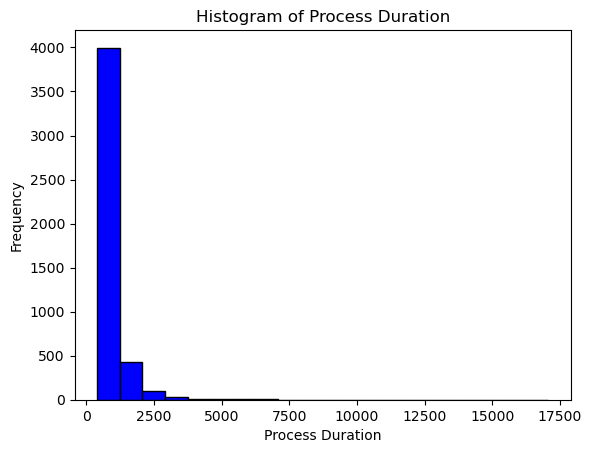

In [40]:
# Create a histogram of the 'process_duration' column
plt.hist(filtered_df['total_time_spent'], bins=20, color='blue', edgecolor='black')

# Add labels and a title
plt.xlabel('Process Duration')
plt.ylabel('Frequency')
plt.title('Histogram of Process Duration')

# Display the plot
plt.show()

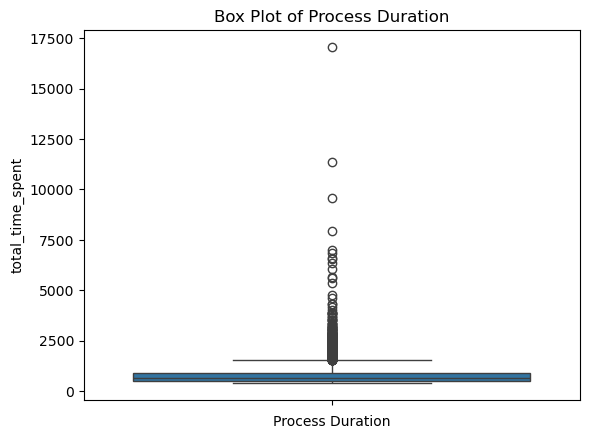

In [42]:
# Box plot to visualize the distribution of 'process_duration'
sns.boxplot(y=filtered_df['total_time_spent'])

# Add title and labels
plt.title('Box Plot of Process Duration')
plt.xlabel('Process Duration')

# Display the plot
plt.show()

In [44]:
# Calculate Q1, Q3 and IQR
Q1 = filtered_df['total_time_spent'].quantile(0.25)
Q3 = filtered_df['total_time_spent'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_filtered = filtered_df[(filtered_df['total_time_spent'] >= lower_bound) & (filtered_df['total_time_spent'] <= upper_bound)]

# Check the shape of the new dataframe (rows after removing outliers)
print(f"Original data: {df.shape[0]} rows, Filtered data: {df_filtered.shape[0]} rows")

Original data: 140482 rows, Filtered data: 4238 rows


In [46]:
df_filtered

,client_id,visitor_id,visit_id,start_time,confirm_time,total_time_spent
4,6642,378857471_644475492,261034804_26267268728_251909,2017-04-19 12:20:35,2017-04-19 12:27:58,443.0
6,6985,157368510_91928042506,702486929_79839403728_901057,2017-04-16 14:14:20,2017-04-16 14:24:46,626.0
9,8101,757154552_88739859416,108937428_94918779072_42035,2017-04-10 08:39:29,2017-04-10 08:55:23,954.0
11,11054,952592414_63731951988,175972021_93800420846_435503,2017-05-16 11:28:36,2017-05-16 11:38:45,609.0
12,11070,615941288_43248755936,681895519_7554253726_390001,2017-04-06 15:05:20,2017-04-06 15:23:25,1085.0
...,...,...,...,...,...,...
14926,9994407,287260289_61350633299,448396755_87385315485_76413,2017-04-23 21:57:03,2017-04-23 22:05:05,482.0
14927,9995084,814602810_36439951509,549856777_44195886165_496779,2017-04-04 00:22:44,2017-04-04 00:30:29,465.0
14930,9996404,336369837_4061930799,943539475_90967917948_823342,2017-03-29 11:59:53,2017-03-29 12:23:03,1390.0
14931,9996711,560523684_67875119133,200256953_19881035574_656660,2017-04-21 19:09:21,2017-04-21 19:20:47,686.0


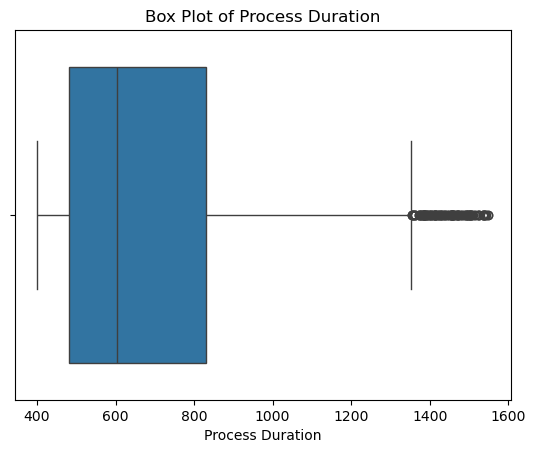

In [48]:
# Box plot to visualize the distribution of 'process_duration'
sns.boxplot(x=df_filtered['total_time_spent'])

# Add title and labels
plt.title('Box Plot of Process Duration')
plt.xlabel('Process Duration')

# Display the plot
plt.show()

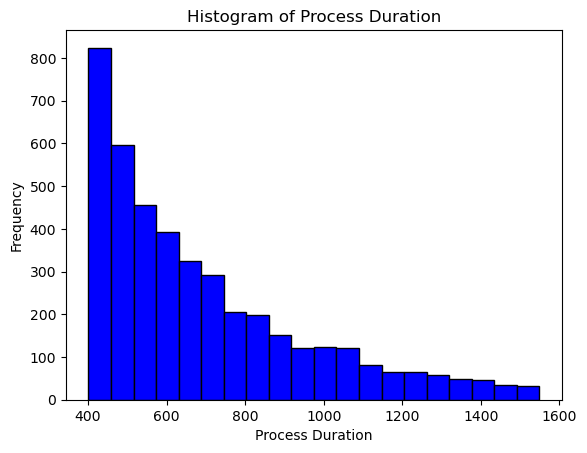

In [50]:
# Create a histogram of the 'process_duration' column
plt.hist(df_filtered['total_time_spent'], bins=20, color='blue', edgecolor='black')

# Add labels and a title
plt.xlabel('Process Duration')
plt.ylabel('Frequency')
plt.title('Histogram of Process Duration')

# Display the plot
plt.show()

In [52]:
# Average of time to complete the process 4,977 rows
df_filtered.total_time_spent.mean()

690.592968381312

In [54]:
# Measures of centrality of the column balance: 
mean_process_duration = df_filtered["total_time_spent"].mean()
median_process_duration = df_filtered['total_time_spent'].median()
mode_process_duration = df_filtered['total_time_spent'].mode()[0]
print(mean_process_duration)
print(median_process_duration)
print(mode_process_duration)

690.592968381312
604.0
409.0


In [56]:
# Measures of dispersion of the column balance: 
variance_process_duration = df_filtered['total_time_spent'].var()
std_dev_process_duration = df_filtered['total_time_spent'].std()
min_process_duration = df_filtered['total_time_spent'].min()
max_process_duration = df_filtered['total_time_spent'].max()
range_process_duration = max_process_duration - min_process_duration
quantiles_process_duration = df_filtered['total_time_spent'].quantile([0.25, 0.5, 0.75])
print(variance_process_duration)
print(std_dev_process_duration)
print(min_process_duration)
print(max_process_duration)
print(range_process_duration)
print(quantiles_process_duration)

70935.82649763014
266.33780523543805
401.0
1549.0
1148.0
0.25    482.00
0.50    604.00
0.75    830.75
Name: total_time_spent, dtype: float64


In [58]:
skewness_process_duration = df_filtered['total_time_spent'].skew()
kurtosis_process_duration = df_filtered['total_time_spent'].kurtosis()
print(skewness_process_duration)
print(kurtosis_process_duration)

1.1598693278091452
0.6210250702815281


In [60]:
# Calculate the time difference between consecutive steps for each user
df['time_diff'] = df.groupby(['client_id', 'visitor_id', 'visit_id'])['date_time'].diff()
df['time_diff']

8                    NaT
7        0 days 00:00:49
6        0 days 00:01:03
5        0 days 00:00:09
4        0 days 00:04:35
               ...      
140473   0 days 00:00:16
140472   0 days 00:00:14
140470   0 days 00:07:03
140471   0 days 00:00:00
140481               NaT
Name: time_diff, Length: 140482, dtype: timedelta64[ns]

In [62]:
df['time_diff_seconds'] = df['time_diff'].dt.total_seconds()
df['time_diff_seconds']

8           NaN
7          49.0
6          63.0
5           9.0
4         275.0
          ...  
140473     16.0
140472     14.0
140470    423.0
140471      0.0
140481      NaN
Name: time_diff_seconds, Length: 140482, dtype: float64

In [68]:
total_time_per_user_seconds = df.groupby('client_id')['time_diff_seconds'].sum()
total_time_per_user_seconds

client_id
1028        538.0
1104          0.0
1186         22.0
1195        245.0
1197         95.0
            ...  
9997125     178.0
9997391     223.0
9997470    2626.0
9998346     748.0
9998921       0.0
Name: time_diff_seconds, Length: 23526, dtype: float64

In [70]:
# Convert the total time from seconds to a more readable format (e.g., minutes, hours)
total_time_per_user_minutes = total_time_per_user_seconds / 60
total_time_per_user_hours = total_time_per_user_seconds / 3600
total_time_per_user_minutes

client_id
1028        8.966667
1104        0.000000
1186        0.366667
1195        4.083333
1197        1.583333
             ...    
9997125     2.966667
9997391     3.716667
9997470    43.766667
9998346    12.466667
9998921     0.000000
Name: time_diff_seconds, Length: 23526, dtype: float64

In [72]:
total_time_per_user_seconds.mean()

384.3141630536428

In [74]:
total_time_per_user_minutes.mean()

6.405236050894047

In [76]:
total_time_per_user_hours.mean()

0.10675393418156744

In [78]:
df = df.dropna(subset=['time_diff_seconds'])

In [80]:
df.time_diff_seconds.mean()

83.52540948017035

In [82]:
# Group by 'process_step' and calculate the average time spent in each step
avg_time_per_step = df.groupby('process_step')['time_diff_seconds'].mean().reset_index()
avg_time_per_step

,process_step,time_diff_seconds
0,confirm,129.959073
1,start,174.742134
2,step_1,43.186201
3,step_2,38.844172
4,step_3,94.170056


In [84]:
df_time_start= df[df["process_step"]=="start"]["time_diff_seconds"]
df_time_step1= df[df["process_step"]=="step_1"]["time_diff_seconds"]
df_time_step2= df[df["process_step"]=="step_2"]["time_diff_seconds"]
df_time_step3= df[df["process_step"]=="step_3"]["time_diff_seconds"]
df_time_confirm= df[df["process_step"]=="confirm"]["time_diff_seconds"]

In [86]:
#Set the hypothesis

#H0: mu_start time control = mu_confirm time control
#H1: mu_start time test != mu_confirm time group

#significance level = 0.05

st.ttest_ind(df_time_start,df_time_confirm, equal_var=False, alternative="two-sided")

TtestResult(statistic=9.541671975575547, pvalue=1.5836709645110198e-21, df=17679.08659357926)

## Interpretation:
The t-statistic of 9.54 indicates a large difference between the groups (or means being compared).
The p-value of 
1.58
×
1
0
−
21
1.58×10 
−21
  is extremely small, suggesting that the null hypothesis (no difference) can almost certainly be rejected. This means the result is highly significant statistically.
The degrees of freedom of approximately 17,679 suggests that the sample size is quite large.
## Conclusion:
Based on these results, the difference between the two groups being compared is statistically significant, with a very small probability that this result is due to random chance. You can confidently reject the null hypothesis and conclude that the groups (or conditions) differ in a meaningful way.

In [88]:
# Filter the visit_id where total time spent is 0.00 seconds
zero_time_visits = total_time_per_user_seconds[total_time_per_user_seconds == 0.00]

# Display the result
print(zero_time_visits)

visit_id
100030127_47967100085_936361    0.0
100071743_53464757454_616703    0.0
100398738_80691628792_341470    0.0
10043239_12589390657_342180     0.0
100647528_93869859601_746654    0.0
                               ... 
999361543_62254499363_553280    0.0
999513613_73210791259_872482    0.0
999622448_77471275609_430955    0.0
999669588_11693809578_22026     0.0
999951892_54774917180_163890    0.0
Name: time_diff_seconds, Length: 5667, dtype: float64


In [100]:
# Filter the visit_id where total time spent is greater than 0.00 seconds
positive_time_visits = total_time_per_user_seconds[total_time_per_user_seconds > 60]

# Sort the results in ascending order
sorted_positive_time_visits = positive_time_visits.sort_values()

# Display the result
print(sorted_positive_time_visits)

visit_id
795246645_69149507465_313202       61.0
243749571_7341374965_63177         61.0
911029496_61078509102_959337       61.0
855166464_44913906706_757013       61.0
142659492_98430385335_762066       61.0
                                 ...   
548692827_385358773_951099      10163.0
627596734_90499955288_891366    11351.0
588904389_16165570985_286826    17072.0
483738263_4057680487_61869      22895.0
831987489_84761163210_335684    41965.0
Name: time_diff_seconds, Length: 21783, dtype: float64


In [102]:
# Filter the visit_id where total time spent is between 60 and 519.60 seconds
filtered_visits = total_time_per_user_seconds[(total_time_per_user_seconds > 60) & (total_time_per_user_seconds < 519.60)]

# Sort the results in ascending order
sorted_filtered_visits = filtered_visits.sort_values()

# Display the result
print(sorted_filtered_visits)

visit_id
805125802_31386152205_848457     61.0
341867008_72237627856_254153     61.0
893033628_33064989240_803510     61.0
243749571_7341374965_63177       61.0
295330855_85099364273_545655     61.0
                                ...  
632305734_34095328044_299168    519.0
984144087_82979751271_861504    519.0
245158227_56218939469_469940    519.0
426477072_55789424877_412293    519.0
880025264_18311482672_399721    519.0
Name: time_diff_seconds, Length: 17186, dtype: float64


In [108]:
# Filter the rows where process_duration is less than 8.66 minutes 
filtered_visits = df_filtered[df_filtered['process_duration'] < 8.66]

# Sort the filtered DataFrame by 'process_duration' in ascending order
sorted_filtered_visits = filtered_visits.sort_values(by='process_duration')

# Now, if you want to get the visit_ids sorted by process_duration:
visit_ids_sorted = sorted_filtered_visits['visit_id']

# Print the sorted visit_ids
print(visit_ids_sorted)

29046    946265061_31258158249_512684
17934    626140106_55660748234_763451
27831    909819300_16166315887_693875
4110     218979770_56709644111_553967
18967    654700708_51014988677_633115
                     ...             
10535    409891944_58325073292_104522
18144    632305734_34095328044_299168
25247     834489877_1354695935_880911
9490     378473111_39661873868_477944
17141    602075125_40566017690_774906
Name: visit_id, Length: 3080, dtype: object


In [110]:
sorted_filtered_visits

,visit_id,start_time,confirm_time,process_duration
29046,946265061_31258158249_512684,2017-03-29 13:37:44,2017-03-29 13:42:55,5.183333
17934,626140106_55660748234_763451,2017-05-14 13:45:49,2017-05-14 13:51:00,5.183333
27831,909819300_16166315887_693875,2017-04-05 17:23:37,2017-04-05 17:28:48,5.183333
4110,218979770_56709644111_553967,2017-04-17 15:39:52,2017-04-17 15:45:03,5.183333
18967,654700708_51014988677_633115,2017-03-30 13:05:02,2017-03-30 13:10:13,5.183333
...,...,...,...,...
10535,409891944_58325073292_104522,2017-04-21 10:39:04,2017-04-21 10:47:43,8.650000
18144,632305734_34095328044_299168,2017-05-11 06:30:08,2017-05-11 06:38:47,8.650000
25247,834489877_1354695935_880911,2017-04-15 16:07:00,2017-04-15 16:15:39,8.650000
9490,378473111_39661873868_477944,2017-04-05 17:27:42,2017-04-05 17:36:21,8.650000


In [182]:
# Assuming you have your DataFrame loaded into a variable called df
# Filter the rows where visit_id matches the specific visit_id
visit_id_to_check = "946265061_31258158249_512684"
filter_df = df[df['visit_id'] == visit_id_to_check]

# To display the filtered data
print(filter_df)

       client_id           visitor_id                      visit_id  \
80580    5762741  84208227_6311756212  946265061_31258158249_512684   
80579    5762741  84208227_6311756212  946265061_31258158249_512684   
80578    5762741  84208227_6311756212  946265061_31258158249_512684   
80577    5762741  84208227_6311756212  946265061_31258158249_512684   

      process_step           date_time  clnt_tenure_yr  clnt_tenure_mnth  \
80580       step_1 2017-03-29 13:38:04            10.0             122.0   
80579       step_2 2017-03-29 13:38:13            10.0             122.0   
80578       step_3 2017-03-29 13:40:47            10.0             122.0   
80577      confirm 2017-03-29 13:42:55            10.0             122.0   

       clnt_age gendr  num_accts       bal  calls_6_mnth  logons_6_mnth  \
80580      33.5     M        2.0  80761.42           1.0            4.0   
80579      33.5     M        2.0  80761.42           1.0            4.0   
80578      33.5     M        2.0  8076

In [185]:
# Export DataFrame to CSV
df_filtered.to_csv('control_group_filtered.csv', index=False)